a public educational dataset shared by UK Open University.

data:

https://analyse.kmi.open.ac.uk/open_dataset \
https://www.kaggle.com/datasets/rocki37/open-university-learning-analytics-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import sklearn

pd.options.mode.chained_assignment = None

from pandas.core.common import flatten
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import logistic

###  Courses Table ###

“B” for the presentation starting in February \
“J” for the presentation starting in October.

In [2]:
courses = pd.read_csv('dataset/courses.csv')

print('shape=',courses.shape)
courses.head()

shape= (22, 3)


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


**1:** duplicate/missing values

In [3]:
print('missing values =',courses.isna().sum().sum())
print('duplicated values =',courses.duplicated().sum().sum())

missing values = 0
duplicated values = 0


**2:** courses started in February vs October

In [4]:
february = courses.code_presentation.str.contains('B',regex=False)
october = courses.code_presentation.str.contains('J',regex=False)

feb_sum = february.sum()
oct_sum = october.sum()

if feb_sum > oct_sum :
    print('February is more than October')
elif feb_sum < oct_sum :
    print('October is more than February')
elif feb_sum == oct_sum :
    print('October is equal February')

October is more than February


**3:** courses that were offered two years consecutively in the same semester

In [5]:
courses_feb = courses.code_module.loc[february]
courses_oct = courses.code_module.loc[october]

courses_feb_consecutively = courses_feb.loc[courses_feb.duplicated()]
courses_oct_consecutively = courses_oct.loc[courses_oct.duplicated()]

print('Courses that were offered two years consecutively in February')
print(list(courses_feb_consecutively))
print('Courses that were offered two years consecutively in October')
print(list(courses_oct_consecutively))

if courses_feb_consecutively.size == courses_oct_consecutively.size :
    print('they had the same length')
else :
    print('they had not the same length')

Courses that were offered two years consecutively in February
['BBB', 'DDD', 'FFF']
Courses that were offered two years consecutively in October
['AAA', 'BBB', 'DDD', 'EEE', 'FFF', 'GGG']
they had not the same length


**4:** courses that were offered in two consecutive semesters of the same year

In [6]:
courses_2013 = courses.code_presentation.str.contains('2013',regex=False)
courses_2014 = courses.code_presentation.str.contains('2014',regex=False)

courses_2013 = courses.code_module.loc[courses_2013]
courses_2014 = courses.code_module.loc[courses_2014]

courses_2013_consecutively = courses_2013.loc[courses_2013.duplicated()]
courses_2014_consecutively = courses_2014.loc[courses_2014.duplicated()]

print('Courses that were offered two semesters consecutively in 2013')
print(list(courses_2013_consecutively))
print('Courses that were offered two semesters consecutively in 2014')
print(list(courses_2014_consecutively))

if courses_2013_consecutively.size == courses_2014_consecutively.size :
    print('they had the same length')
else :
    print('they had not the same length')

Courses that were offered two semesters consecutively in 2013
['BBB', 'DDD', 'FFF']
Courses that were offered two semesters consecutively in 2014
['BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG']
they had not the same length


### Student Info Table

In [7]:
student_info = pd.read_csv('dataset/studentInfo.csv')
student_info.imd_band.loc[student_info.imd_band.isin(['10-20'])] = '10-20%'

print('shape=',student_info.shape)
student_info.head()

shape= (32593, 12)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


**1:** duplicate/missing values

In [8]:
print('dublicated rows=',student_info.duplicated().sum(),'\n')
print('na colums=',student_info.isna().sum().loc[~(student_info.isna().sum() ==0)])

dublicated rows= 0 

na colums= imd_band    1111
dtype: int64


**2:** Categorical variables

**2.1:** highest_education

`Post Graduate Qualification` and `No Formal quals` counts are small so

I  add `Post Graduate Qualification` to `HE Qualification` \
I  add `No Formal quals` to `Lower Than A level`

I also add catogeries `1-2-3` for shorting level 1 is low level 3 is high level

In [9]:
print(student_info.highest_education.value_counts(), '\n')

student_info.highest_education.replace(['No Formal quals'],['Lower Than A Level'],inplace=True)
student_info.highest_education.replace(['Post Graduate Qualification'],['HE Qualification'],inplace=True)

student_info.highest_education.replace(['Lower Than A Level','A Level or Equivalent','HE Qualification'],
                                       ['1_Lower Than A Level','2_A Level or Equivalent','3_HE Qualification'],inplace=True)

print(student_info.highest_education.value_counts())

A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: highest_education, dtype: int64 

2_A Level or Equivalent    14045
1_Lower Than A Level       13505
3_HE Qualification          5043
Name: highest_education, dtype: int64


**2.2:** age_band

`55<=` counts are small so I add it to `35-55`

rename values `0-35` --> `35>=` and `35-55` --> `35<=`

In [10]:
print(student_info.age_band.value_counts(),'\n')
student_info.age_band.replace(['55<='],['35-55'],inplace=True)

student_info.age_band.replace(['0-35','35-55'],['35>=','35<='],inplace=True)
print(student_info.age_band.value_counts())


0-35     22944
35-55     9433
55<=       216
Name: age_band, dtype: int64 

35>=    22944
35<=     9649
Name: age_band, dtype: int64


**2.3:** imd_band

bands counts are near but 10% difference is too small so I set difference 20%

In [11]:
print(student_info.imd_band.value_counts().sort_index(), '\n')

replacement_list = [(['0-10%','10-20%'],'0-20%'),
                    (['20-30%','30-40%'],'20-40%'),
                    (['40-50%','50-60%'],'40-60%'),
                    (['60-70%','70-80%'],'60-80%'),
                    (['80-90%','90-100%'],'80-100%')]

student_info.imd_band.replace(['0-10%','20-30%','40-50%','60-70%','80-90%'],
                              ['0-20%','20-40%','40-60%','60-80%','80-100%'],inplace=True)

student_info.imd_band.replace(['10-20%','30-40%','50-60%','70-80%','90-100%'],
                              ['0-20%','20-40%','40-60%','60-80%','80-100%'],inplace=True)


print(student_info.imd_band.value_counts().sort_index(), '\n')


0-10%      3311
10-20%     3516
20-30%     3654
30-40%     3539
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: imd_band, dtype: int64 

0-20%      6827
20-40%     7193
40-60%     6380
60-80%     5784
80-100%    5298
Name: imd_band, dtype: int64 



**2.4:** num_of_prev_attempts

`1,2,3,4,5,6` attempts are much less than `0` attempts so I collect `1,2,3,4,5,6` to `1+`

In [12]:
print(student_info.num_of_prev_attempts.value_counts(),'\n')

student_info.num_of_prev_attempts.replace([1,2,3,4,5,6],'GT 1',inplace=True)
print(student_info.num_of_prev_attempts.value_counts())


0    28421
1     3299
2      675
3      142
4       39
5       13
6        4
Name: num_of_prev_attempts, dtype: int64 

0       28421
GT 1     4172
Name: num_of_prev_attempts, dtype: int64


**2.4:** Treating NA Values\
imd_band is connected region and highest education so I distrubute na values that imd_band distribution of region and highest education

In [13]:
na_count = pd.crosstab([student_info.region,student_info.highest_education], student_info.imd_band.isna())
na_count.rename(columns={False:'not_na',True:'is_na'},inplace=True)

na_count = na_count.loc[~na_count.is_na.isin([0])]
na_count.head()

imd_band                              not_na  is_na
region       highest_education                     
Ireland      1_Lower Than A Level        403     78
             2_A Level or Equivalent     424     57
             3_HE Qualification           91    131
North Region 1_Lower Than A Level        449    288
             2_A Level or Equivalent     543    173

In [14]:
na_count = na_count.is_na

imd_dist = pd.crosstab([student_info.region,student_info.highest_education], student_info.imd_band).loc[na_count.index]
imd_dist_ratio = imd_dist.apply(lambda x: x/x.sum(),axis=1)

na_dist = imd_dist_ratio.apply(lambda x: x*np.array(na_count)).round()
na_dist.iloc[:,2] += na_count-na_dist.sum(axis=1)
na_dist.head()

imd_band                              0-20%  20-40%  40-60%  60-80%  80-100%
region       highest_education                                              
Ireland      1_Lower Than A Level      23.0    16.0    15.0    15.0      9.0
             2_A Level or Equivalent   14.0    10.0    13.0     9.0     11.0
             3_HE Qualification        14.0    17.0    15.0    49.0     36.0
North Region 1_Lower Than A Level     119.0    78.0    40.0    38.0     13.0
             2_A Level or Equivalent   68.0    37.0    27.0    28.0     13.0

In [15]:
pd.Series(na_count-na_dist.sum(axis=1),name='difference').head()

region        highest_education      
Ireland       1_Lower Than A Level       0.0
              2_A Level or Equivalent    0.0
              3_HE Qualification         0.0
North Region  1_Lower Than A Level       0.0
              2_A Level or Equivalent    0.0
Name: difference, dtype: float64

In [16]:
na_dist_sec = na_dist.stack().reset_index().rename(columns={0:'na_count'})
na_dist_sec = na_dist_sec[~(na_dist_sec.na_count == 0)]

na_dist_end = pd.DataFrame(np.repeat(na_dist_sec.values,na_dist_sec.na_count,axis=0))
na_dist_end.columns = na_dist_sec.columns
na_dist_end.index = student_info.loc[student_info.imd_band.isna()].sort_values(['region','highest_education']).index
na_dist_end.drop(['na_count'],axis=1,inplace=True)

print('na_dist_end is sorted. If I also short student_info.isna() data they are same \n')
student_info.fillna(na_dist_end,inplace = True)
na_dist_end.head()

na_dist_end is sorted. If I also short student_info.isna() data they are same 



,region,highest_education,imd_band
184,Ireland,1_Lower Than A Level,0-20%
578,Ireland,1_Lower Than A Level,0-20%
636,Ireland,1_Lower Than A Level,0-20%
1141,Ireland,1_Lower Than A Level,0-20%
3646,Ireland,1_Lower Than A Level,0-20%


In [17]:
print('na count is ',student_info.isna().sum().sum())
na_dist_end.head()
student_info.loc[na_dist_end.head().index,['region','highest_education','imd_band']]

na count is  0


,region,highest_education,imd_band
184,Ireland,1_Lower Than A Level,0-20%
578,Ireland,1_Lower Than A Level,0-20%
636,Ireland,1_Lower Than A Level,0-20%
1141,Ireland,1_Lower Than A Level,0-20%
3646,Ireland,1_Lower Than A Level,0-20%


**3:** Demographic Information and Performance Levels

relationships between `final_result` and `highest education`,`imd_band`,`age_band` and `num_of_prev_attempts`

Obviously seen that; 

When increase education level and and imd band, \
Distinction and Pass counts are incerase. Also, Fail and Withdrawn counts are decrease.

When increase age and and num of prev attempts, \
Distinction and Pass counts are decrease. Also, Fail and Withdrawn counts are increase.



<AxesSubplot:title={'center':'num of prev attempts vs final result'}, xlabel='num_of_prev_attempts', ylabel='count'>

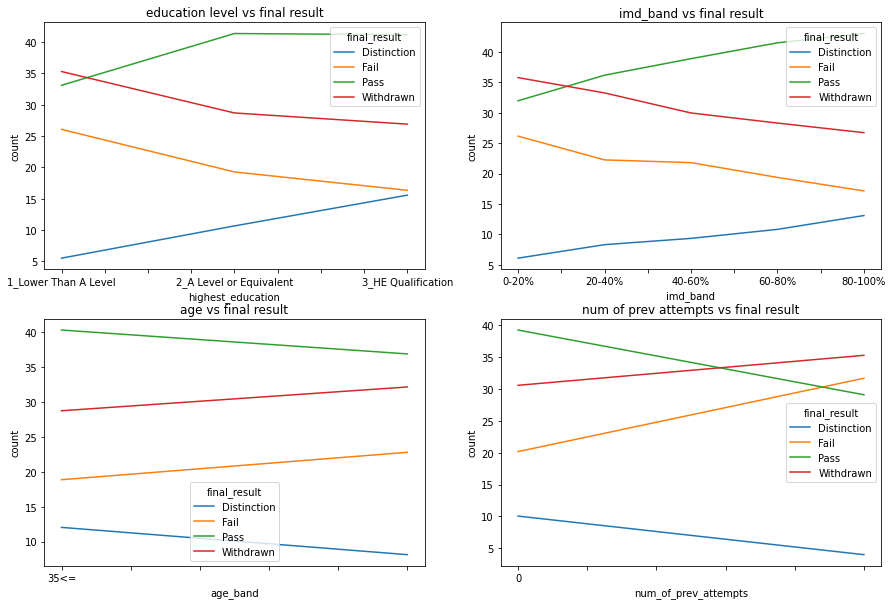

In [18]:
edu = pd.crosstab(student_info.highest_education, student_info.final_result).apply(lambda x: x*100/x.sum(),axis=1)
imd = pd.crosstab(student_info.imd_band, student_info.final_result).apply(lambda x: x*100/x.sum(),axis=1)
age = pd.crosstab(student_info.age_band, student_info.final_result).apply(lambda x: x*100/x.sum(),axis=1)
attempt =pd.crosstab(student_info.num_of_prev_attempts, student_info.final_result).apply(lambda x: x*100/x.sum(),axis=1)

fig, axes = plt.subplots(2,2)

edu.plot(title='education level vs final result',ylabel='count',ax=axes[0,0],figsize=(15,10))
imd.plot(title='imd_band vs final result',ylabel='count',ax=axes[0,1])
age.plot(title='age vs final result',ylabel='count',ax=axes[1,0])
attempt.plot(title='num of prev attempts vs final result',ylabel='count',ax=axes[1,1])

###  Registration Table

In [19]:
student_registration = pd.read_csv('dataset/studentRegistration.csv')

print('shape=',student_registration.shape)
student_registration.head()

shape= (32593, 5)


,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


**1:** conflicts between `studentRegistration.csv` and `studentInfo.csv` dataset in terms of `Withdrawal` status of `unregistered` students 

In [20]:
registrations = student_registration.merge(student_info)

print(registrations.final_result[registrations.date_unregistration.notna()].value_counts())

registrations.final_result.loc[registrations.date_unregistration.notna()] = 'Withdrawn'

print(registrations.final_result[registrations.date_unregistration.notna()].value_counts())
registrations.head()

Withdrawn    10063
Fail             9
Name: final_result, dtype: int64
Withdrawn    10072
Name: final_result, dtype: int64


,code_module,code_presentation,id_student,date_registration,date_unregistration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,-159.0,NaN,M,East Anglian Region,3_HE Qualification,80-100%,35<=,0,240,N,Pass
1,AAA,2013J,28400,-53.0,NaN,F,Scotland,3_HE Qualification,20-40%,35<=,0,60,N,Pass
2,AAA,2013J,30268,-92.0,12.0,F,North Western Region,2_A Level or Equivalent,20-40%,35<=,0,60,Y,Withdrawn
3,AAA,2013J,31604,-52.0,NaN,F,South East Region,2_A Level or Equivalent,40-60%,35<=,0,60,N,Pass
4,AAA,2013J,32885,-176.0,NaN,F,West Midlands Region,1_Lower Than A Level,40-60%,35>=,0,60,N,Pass


**2:** Categorize students based on the day they registered for a course.

In [21]:
perf_groups = ["Very early birds","early birds",'in_time',"late-comers","very late-comers"]

data = registrations.date_registration.copy()
bins = [data.min(), (data.min()-30)/2, -30, 10, (data.max()+10)/2, data.max()]
print(bins)


cats_regist = pd.cut(registrations.date_registration, bins, labels= perf_groups, right=True)

cats_regist.head()

[-322.0, -176.0, -30, 10, 88.5, 167.0]


0         early birds
1         early birds
2         early birds
3         early birds
4    Very early birds
Name: date_registration, dtype: category
Categories (5, object): ['Very early birds' < 'early birds' < 'in_time' < 'late-comers' < 'very late-comers']

**3:** Categorize students based on the day they *unregistered* a course.

In [22]:
perf_groups = ["Very early unregistered","early unregistered","in-time unregistered",
               "late unregistered","very late unregistered"]

data = registrations.date_unregistration.copy()
bins = [data.min(), (data.min()-30)/2, -30, 10, (data.max()+10)/2, data.max()]
print(bins)

cats_unregist = pd.cut(registrations.date_unregistration, bins, labels= perf_groups, right=True)
cats_unregist.head()

[-365.0, -197.5, -30, 10, 227.0, 444.0]


0                  NaN
1                  NaN
2    late unregistered
3                  NaN
4                  NaN
Name: date_unregistration, dtype: category
Categories (5, object): ['Very early unregistered' < 'early unregistered' < 'in-time unregistered' < 'late unregistered' < 'very late unregistered']

**4:** relationship between students' registration/unregistration behaviour and the chosen demographic variables

In region; \
Ireland and Wales register in-time more than other regions \
Ireland and Wales unregister late more than other regions \
Also, Scotland unregister late a litte more than other regions 

In imd_band, there is not significant difference 

In education level, HE qualificition register in-time a littre more than other education levels


<AxesSubplot:title={'center':'education level vs unregister date'}, xlabel='highest_education', ylabel='count'>

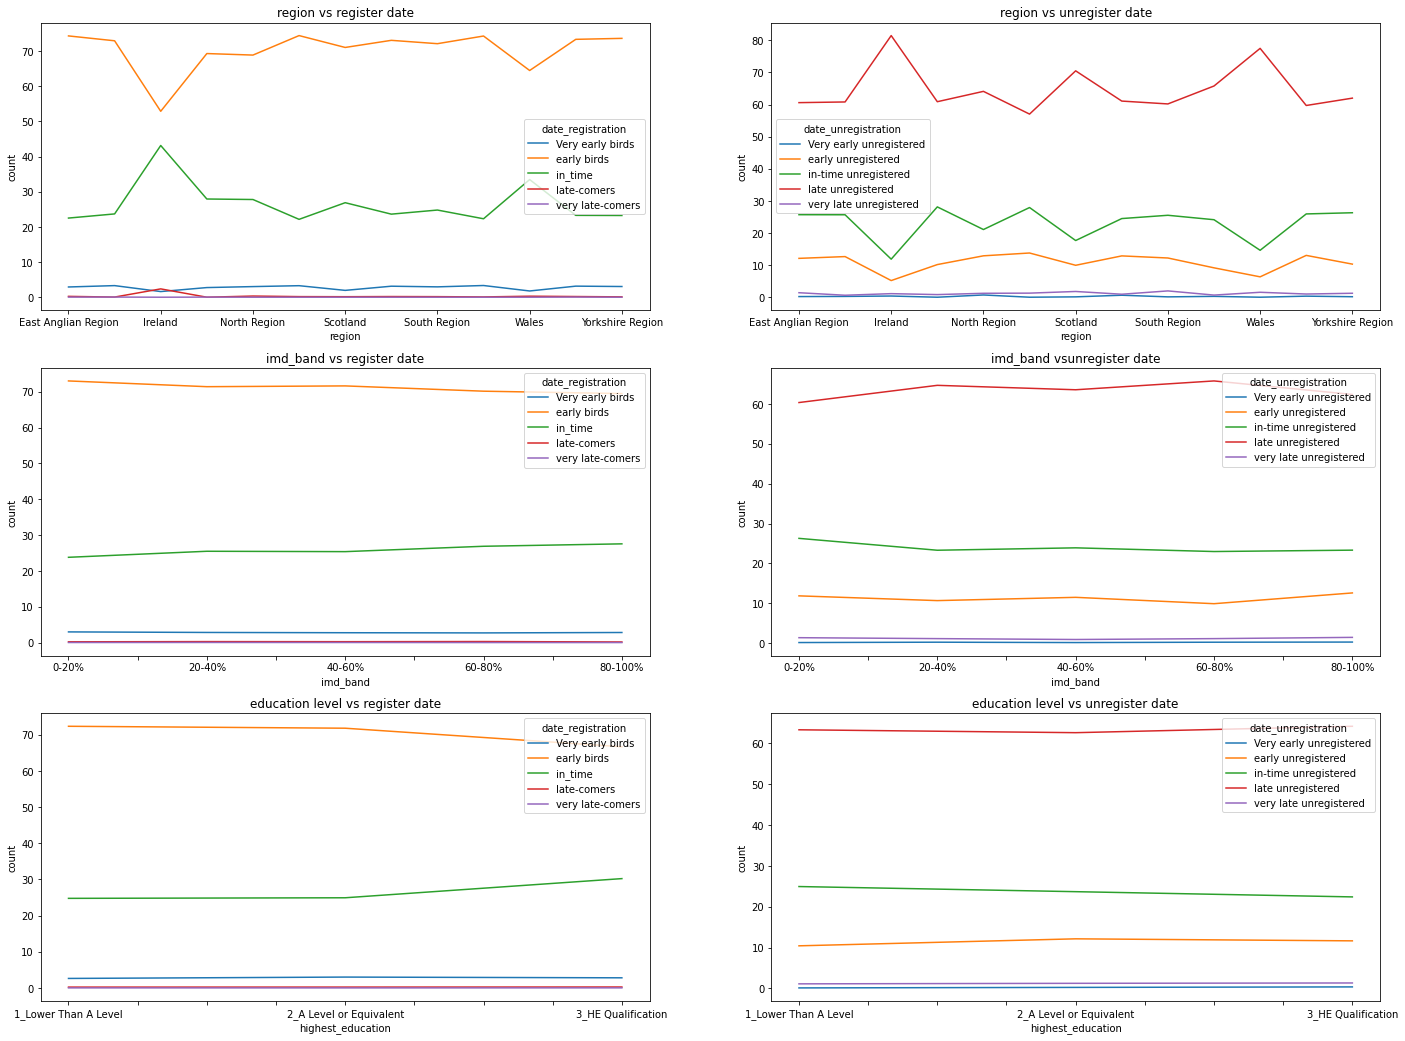

In [23]:
edu_regist = pd.crosstab(registrations.highest_education, cats_regist).apply(lambda x: x*100/x.sum(),axis=1)
edu_unregist = pd.crosstab(registrations.highest_education, cats_unregist).apply(lambda x: x*100/x.sum(),axis=1)

imd_regist = pd.crosstab(registrations.imd_band, cats_regist).apply(lambda x: x*100/x.sum(),axis=1)
imd_unregist = pd.crosstab(registrations.imd_band, cats_unregist).apply(lambda x: x*100/x.sum(),axis=1)

region_regist = pd.crosstab(registrations.region, cats_regist).apply(lambda x: x*100/x.sum(),axis=1)
region_unregist = pd.crosstab(registrations.region, cats_unregist).apply(lambda x: x*100/x.sum(),axis=1)

fig, axes = plt.subplots(3,2)

region_regist.plot(title='region vs register date',ylabel='count',ax=axes[0,0],figsize=(24,18))
region_unregist.plot(title='region vs unregister date',ylabel='count',ax=axes[0,1])

imd_regist.plot(title='imd_band vs register date',ylabel='count',ax=axes[1,0])
imd_unregist.plot(title='imd_band vsunregister date',ylabel='count',ax=axes[1,1])

edu_regist.plot(title='education level vs register date',ylabel='count',ax=axes[2,0])
edu_unregist.plot(title='education level vs unregister date',ylabel='count',ax=axes[2,1])

### Course Components Table

In [24]:
moodle = pd.read_csv('dataset/moodle.csv')

print('shape=',moodle.shape)
moodle.head()

shape= (6364, 6)


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


**1:** some columns contain mainly missing values. Detect and drop them to save space in the memory. 

In [25]:
moodle.dropna(axis=1, inplace=True)
moodle.head()

,id_site,code_module,code_presentation,activity_type
0,546943,AAA,2013J,resource
1,546712,AAA,2013J,oucontent
2,546998,AAA,2013J,resource
3,546888,AAA,2013J,url
4,547035,AAA,2013J,resource


**2:** top 5 popular course component (`activity_type`) across all courses. \
table of these popular components were included in each offering (`code_presentation`) of each course (`code_module`).

one or two activity type of each course were mostly preferred in all 4 semesters. \
For example,\
table says that BBB courses resource is better than other 4 activity type because students mostly use resource.

In [26]:
activity_list = list(moodle.activity_type.value_counts().index) # shorted
top5 = activity_list[:5]

moodle_new = pd.crosstab([moodle.code_module,moodle.code_presentation],moodle.activity_type)[activity_list]
moodle_new[top5].head()

activity_type                  resource  subpage  oucontent  url  forumng
code_module code_presentation                                            
AAA         2013J                    95        6         68   18       15
            2014J                    93        6         68   20        6
BBB         2013B                   236       37          1   15       17
            2013J                   236       38          3   15       19
            2014B                   231       37          3   14       17

###  Student Activity Data

In [27]:
moodle_interact = pd.read_csv('dataset/studentMoodleInteract.csv')

print('shape=',moodle_interact.shape)
moodle_interact.head()

shape= (10655280, 6)


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


**1:** the total number of clicks for each course per each semester delivered

<AxesSubplot:xlabel='code_module', ylabel='sum_click'>

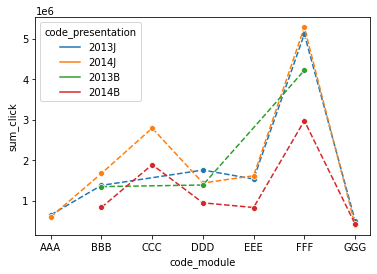

In [28]:
click_sum = moodle_interact.loc[:,['code_module','code_presentation','sum_click']].groupby(['code_module','code_presentation']).sum()
sns.lineplot(data=click_sum, x="code_module", y="sum_click", hue="code_presentation",marker="o", linestyle='dashed')

**2**: the courses in which the total number of clicks is higher in 2014 than 2013.\
If the course was taught two times in the same year take the average of both semesters to compare with the other year.

In [29]:
sum_click_sem = click_sum.unstack().fillna(0).sum_click
sum_click_sem

code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
AAA,0.0,648494.0,0.0,598158.0
BBB,1347911.0,1378656.0,833865.0,1673744.0
CCC,0.0,0.0,1889177.0,2792972.0
DDD,1387467.0,1757214.0,947657.0,1437751.0
EEE,0.0,1535953.0,832038.0,1616236.0
FFF,4220055.0,5116439.0,2975619.0,5281809.0
GGG,0.0,509091.0,425165.0,399628.0


In [30]:
print('Courses that he total number of clicks is higher in 2014 than 2013:')

list(sum_click_sem.index.get_level_values('code_module')[sum_click_sem.loc[:,['2013B','2013J']].mean(axis=1)
                                                         <
                                                         sum_click_sem.loc[:,['2014B','2014J']].mean(axis=1)])

Courses that he total number of clicks is higher in 2014 than 2013:


['CCC', 'EEE', 'GGG']

**3:** resources were mostly clicked by the students.

In [31]:
print('resource is higher than quiz:\n')
moodle_new.resource.unstack().fillna(0).sum(axis=1) > moodle_new.quiz.unstack().fillna(0).sum(axis=1)

resource is higher than quiz:



code_module
AAA    True
BBB    True
CCC    True
DDD    True
EEE    True
FFF    True
GGG    True
dtype: bool

top5 activity type is almost top5 activty type of each course

In [32]:
top5_each_course = pd.DataFrame(pd.crosstab(moodle.code_module,
                                moodle.activity_type).apply(lambda x: list(x.nlargest(n=5).index),
                                                            axis=1))

top5_each_course = top5_each_course.apply(lambda x: x.explode(str(x)).T,axis=1)
print(top5_each_course)
top5_each_course.isin(top5)

                     0          1          2        3          4
code_module                                                     
AAA           resource  oucontent        url  forumng    subpage
BBB           resource    subpage  oucontent  forumng        url
CCC           resource  oucontent    subpage     quiz        url
DDD           resource    subpage        url  forumng  oucontent
EEE          oucontent   resource    subpage      url    forumng
FFF                url   resource  oucontent  subpage       page
GGG           resource  oucontent       quiz  subpage    forumng


,0,1,2,3,4
code_module,,,,,
AAA,True,True,True,True,True
BBB,True,True,True,True,True
CCC,True,True,True,False,True
DDD,True,True,True,True,True
EEE,True,True,True,True,True
FFF,True,True,True,True,False
GGG,True,True,False,True,True


**4:** total number of clicks per each course component type separately for each course and semester and for each student

In [33]:
clicks = registrations.loc[:,['id_student','code_module','code_presentation']].merge(moodle)

clicks_count = pd.crosstab([clicks.id_student,clicks.code_module,clicks.code_presentation],
                           clicks.activity_type).replace(0,np.nan).reset_index()
clicks_count.head()

activity_type,id_student,code_module,code_presentation,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,3733,DDD,2013J,NaN,NaN,7.0,NaN,16,1.0,1,...,NaN,4.0,NaN,NaN,NaN,NaN,178,NaN,194,44.0
1,6516,AAA,2014J,4.0,NaN,NaN,NaN,6,2.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,93,NaN,6,20.0
2,8462,DDD,2013J,NaN,NaN,7.0,NaN,16,1.0,1,...,NaN,4.0,NaN,NaN,NaN,NaN,178,NaN,194,44.0
3,8462,DDD,2014J,NaN,NaN,5.0,NaN,13,2.0,1,...,NaN,1.0,NaN,NaN,NaN,NaN,169,NaN,110,46.0
4,11391,AAA,2013J,4.0,NaN,NaN,NaN,15,2.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,95,NaN,6,18.0


**TASK5:** relationship between students' course performance and clicks on different resources.

All final results avarage is 11&#177;0.6

,id_student,activity_type_count_avg
final_result,,
Distinction,753792.936177,11.060516
Fail,676653.519381,11.059634
Pass,709940.960197,10.964404
Withdrawn,709527.832268,11.053222


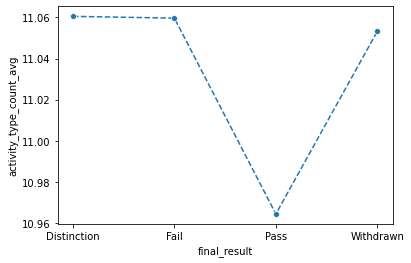

In [34]:
activity_type_sum = pd.Series(clicks_count.drop(['id_student','code_module','code_presentation'],
                                                axis=1).notna().sum(axis=1),name='activity_type_count_sum')

data = pd.concat([registrations.loc[:,['id_student','final_result']],
                  activity_type_sum],axis=1).groupby('final_result').mean().rename(columns={'activity_type_count_sum':
                                                                                            'activity_type_count_avg'})

sns.lineplot(data=data, x="final_result", y="activity_type_count_avg",marker="o", linestyle='dashed')
data

## Predictive Modeling

In [35]:
print(registrations.final_result.value_counts())
#registrations.final_result.replace(['Distinction','Pass'],1,inplace=True)
#registrations.final_result.replace(['Withdrawn','Fail'],0,inplace=True)

registrations.final_result.replace('Distinction','Pass',inplace=True)

print(registrations.final_result.value_counts())

Pass           12361
Withdrawn      10165
Fail            7043
Distinction     3024
Name: final_result, dtype: int64
Pass         15385
Withdrawn    10165
Fail          7043
Name: final_result, dtype: int64


### Generate Features from Demographic Information

 dummy variables : \
 code_module, code_presentation, gender, region, highest_education, imd_band, age_band, 
                   num_of_prev_attempts, disability, registration date category

count =10

In [36]:
dummy_vars = pd.get_dummies(student_info.loc[:,['highest_education','imd_band','age_band','num_of_prev_attempts']])
print(dummy_vars.shape)
dummy_vars.head()

(32593, 12)


,highest_education_1_Lower Than A Level,highest_education_2_A Level or Equivalent,highest_education_3_HE Qualification,imd_band_0-20%,imd_band_20-40%,imd_band_40-60%,imd_band_60-80%,imd_band_80-100%,age_band_35<=,age_band_35>=,num_of_prev_attempts_0,num_of_prev_attempts_GT 1
0,0,0,1,0,0,0,0,1,1,0,1,0
1,0,0,1,0,1,0,0,0,1,0,1,0
2,0,1,0,0,1,0,0,0,1,0,1,0
3,0,1,0,0,0,1,0,0,1,0,1,0
4,1,0,0,0,0,1,0,0,0,1,1,0


### Generate/Select Features from Click Data

features indicating the engagement level of students at different course components

In [37]:
# each student's average number of clicks across all components per a single course and semester

feature1 = clicks_count.drop(['id_student','code_module','code_presentation'],axis=1).mean(axis=1)
feature1 = pd.concat([clicks_count.id_student,feature1],axis=1).rename(columns={0:'feature1'})

print(feature1.shape)
feature1.head()

(32593, 2)


,id_student,feature1
0,3733,46.200000
1,6516,22.444444
2,8462,46.200000
3,8462,36.500000
4,11391,23.444444


In [38]:
# each student's activity type counts that clicks more than 30

feature2 = pd.DataFrame(clicks_count.drop(['id_student','code_module','code_presentation'],axis=1) >30 ).sum(axis=1)
feature2 = pd.concat([clicks_count.id_student,feature2],axis=1).rename(columns={0:'feature2'})

print(feature2.shape)
feature2.head()

(32593, 2)


,id_student,feature2
0,3733,3
1,6516,2
2,8462,3
3,8462,3
4,11391,2


In [39]:
# a dummy variable indicating if students clicked at least 9 course components or not

feature3 = pd.get_dummies(clicks_count.drop(['id_student','code_module','code_presentation'],axis=1)\
                          .notna().sum(axis=1) > 9).rename(columns={True:'true',False:'false'})

feature3 = pd.concat([clicks_count.id_student,feature3],axis=1)

print(feature3.shape)
feature3.head()

(32593, 3)


,id_student,false,true
0,3733,0,1
1,6516,1,0
2,8462,0,1
3,8462,0,1
4,11391,1,0


I have trouble when I use .merge() and, I use concat because all features student id is same. 

In [40]:
pd.DataFrame({'1and2':(feature1.id_student == feature2.id_student),
              '1and3':(feature1.id_student == feature3.id_student)}).sum()

1and2    32593
1and3    32593
dtype: int64

In [41]:
features = pd.concat([feature1,feature2.drop(['id_student'],axis=1),feature3.drop(['id_student'],axis=1)],axis=1)

print(features.shape)
features.head()

(32593, 5)


,id_student,feature1,feature2,false,true
0,3733,46.200000,3,0,1
1,6516,22.444444,2,1,0
2,8462,46.200000,3,0,1
3,8462,36.500000,3,0,1
4,11391,23.444444,2,1,0


### 2.3. Training and Testing the Model

train and test a logistic regression model for predicting students' final course status. 10-fold cross-validation.

In [42]:
X = pd.concat([dummy_vars,features.drop(['id_student'],axis=1)],axis=1)
y = registrations.final_result

In [43]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, random_state=0)
print(len(X_train), len(X_test))

24444 8149


In [44]:
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train,y_train)
knn_classifier.score(X_test,y_test)

0.43882684992023563

In [45]:
scores = cross_val_score(knn_classifier, X, y, cv=10)
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std())) 

[0.45460123 0.44233129 0.43282209 0.43540963 0.42804541 0.4409328
 0.42620436 0.43295489 0.44921755 0.44492176]
Accuracy: 0.44 (+/- 0.01)


In [46]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, random_state=0, test_size=0.33)
print(len(X_train), len(X_test))

classifier = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear', tol=0.05, random_state=0)
classifier.fit(X_train,y_train)

predicted = classifier.predict(X_test)
print('accuracy:',sklearn.metrics.accuracy_score(y_test,predicted))

21837 10756
accuracy: 0.4894942357753812


In [47]:
print('LOGISTIC---------------------------------------------------------------')
print('Classification report for classifier %s:\n%s\n'
    %( classifier, sklearn.metrics.classification_report(y_test, predicted))) 

Confusion_matrix = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predicted))
Confusion_matrix.index = ['Fail','Pass','Whithdrawn']
Confusion_matrix.columns = ['Fail','Pass','Whithdrawn']
Confusion_matrix

LOGISTIC---------------------------------------------------------------
Classification report for classifier LogisticRegression(penalty='l1', random_state=0, solver='liblinear', tol=0.05):
              precision    recall  f1-score   support

        Fail       0.33      0.02      0.04      2304
        Pass       0.51      0.89      0.65      5125
   Withdrawn       0.38      0.20      0.26      3327

    accuracy                           0.49     10756
   macro avg       0.41      0.37      0.32     10756
weighted avg       0.43      0.49      0.40     10756




,Fail,Pass,Whithdrawn
Fail,52,1706,546
Pass,36,4541,548
Whithdrawn,72,2583,672


In [48]:
feature_importance = pd.DataFrame()
feature_importance['coef_'] = pd.DataFrame(data={'coef_': classifier.coef_[0]})[['coef_']]
feature_importance['feature'] = X.columns
feature_importance.sort_values('coef_',ascending=False)

,coef_,feature
11,0.475769,num_of_prev_attempts_GT 1
0,0.060600,highest_education_1_Lower Than A Level
13,0.039436,feature2
12,-0.001989,feature1
15,-0.033705,true
14,-0.056563,false
10,-0.135317,num_of_prev_attempts_0
3,-0.237890,imd_band_0-20%
1,-0.261317,highest_education_2_A Level or Equivalent
2,-0.405301,highest_education_3_HE Qualification


In [49]:
probas_ = classifier.predict_proba(X_test)
print(probas_[:10])

[[0.1456244  0.61628609 0.23808952]
 [0.2310239  0.44901415 0.31996196]
 [0.22104397 0.43165207 0.34730396]
 [0.19475089 0.50879384 0.29645526]
 [0.16891632 0.57288226 0.25820142]
 [0.12712953 0.65627362 0.21659684]
 [0.22792207 0.43725096 0.33482697]
 [0.19121498 0.52521811 0.28356691]
 [0.12372396 0.66134024 0.2149358 ]
 [0.22987866 0.44178437 0.32833697]]


In [50]:
print(X_test.shape)
X_test.head()

(10756, 16)


,highest_education_1_Lower Than A Level,highest_education_2_A Level or Equivalent,highest_education_3_HE Qualification,imd_band_0-20%,imd_band_20-40%,imd_band_40-60%,imd_band_60-80%,imd_band_80-100%,age_band_35<=,age_band_35>=,num_of_prev_attempts_0,num_of_prev_attempts_GT 1,feature1,feature2,false,true
3431,0,0,1,0,0,1,0,0,1,0,1,0,38.909091,3,0,1
26458,1,0,0,0,0,0,1,0,0,1,1,0,24.777778,3,1,0
4137,1,0,0,0,1,0,0,0,1,0,1,0,36.285714,4,0,1
281,1,0,0,0,0,0,1,0,1,0,1,0,31.500000,2,0,1
32525,0,1,0,0,0,1,0,0,1,0,1,0,31.866667,4,0,1


In [51]:
feature_scores_3431 = X_test.loc[3431,:].tolist()
print(feature_scores_3431)

[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 38.90909090909091, 3.0, 0.0, 1.0]


In [52]:
logistic.cdf(np.dot(feature_scores_3431,classifier.coef_[0]) + classifier.intercept_)

array([0.14541993, 0.15620114, 0.13716778])